In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
root = "250815"

r = list()
for file in os.listdir(root):
    # print(file)
    if not file.endswith(".txt"):
        continue
    tokens = file.split(".")[0].split("-")
    if len(tokens) != 4:
        continue
    timestamp = "20"+tokens[1][:2] + "-" + tokens[1][2:4] + "-" + tokens[1][4:6] + " "+tokens[2][:2]+":"+tokens[2][2:4]+":"+tokens[2][4:6]
    cnt = tokens[3][5:]
    # print(timestamp, cnt)

    speed = list()
    height = list()
    max_speed = -1
    with open(root+"/"+file) as f:
        lines = f.readlines()
        for line in lines:
            # 최초 고도 기록: 41.86683 m
            if line.startswith("최초 고도 기록: "):
                
                hstart = float(line.split(":")[1].strip().split()[0])
            # 최고 고도: 37.43045 m, 최저 고도: 36.6272 m, 마지막 고도: 36.78838 m
            if line.startswith("최고 고도: "):
                t = line.split(", ")
                hmax = float(t[0].split(":")[1].strip().split()[0])
                hmin = float(t[1].split(":")[1].strip().split()[0])
                hend = float(t[2].split(":")[1].strip().split()[0])

            # 중력: 9.81 m/s², 총가속도: 11.49 m/s², 고도: 37.40 m

            if line.startswith("중력"):
                t = line.split(", ")
                cspeed = float(t[1].split(":")[1].strip().split()[0])
                if cspeed > max_speed:
                    max_speed = cspeed
                speed.append(cspeed)
                height.append(float(t[2].split(":")[1].strip().split()[0]))
            
            
    r.append(dict(
        timestamp=timestamp,
        phase="",
        cnt=cnt,
        start_height=hstart,
        end_height=hend,
        max_height=hmax,
        min_height=hmin,
        max_speed=max_speed,
        speed=speed,
        height=height,
    ))
    # break
res = pd.DataFrame(r).pipe(
    lambda x: x.assign(
        timestamp=pd.to_datetime(x.timestamp)
    )).sort_values("timestamp").reset_index(drop=True)

# 1단계  가장 높음 - 4단계  가장 낮음
res.loc[(res.timestamp>="2025-08-15 15:01:19")&(res.timestamp<"2025-08-15 15:28:25"), "phase"] = "L5_H1"
res.loc[(res.timestamp>="2025-08-15 15:28:25")&(res.timestamp<"2025-08-15 16:08:55"), "phase"] = "L5_H2"
res.loc[(res.timestamp>="2025-08-15 16:14:50")&(res.timestamp<"2025-08-15 16:24:10"), "phase"] = "L5_H3"
res.loc[(res.timestamp>="2025-08-15 16:24:10")&(res.timestamp<"2025-08-15 16:37:10"), "phase"] = "L5_H4"
res.loc[(res.timestamp>="2025-08-15 16:37:10")&(res.timestamp<"2025-08-15 16:44:50"), "phase"] = "L1_H1"
res.loc[(res.timestamp>="2025-08-15 16:44:50")&(res.timestamp<"2025-08-15 16:54:52"), "phase"] = "L1_H2"
res.loc[(res.timestamp>="2025-08-15 17:40:10")&(res.timestamp<"2025-08-15 17:48:30"), "phase"] = "L1_H3"
res.loc[(res.timestamp>="2025-08-15 17:48:30")&(res.timestamp<"2025-08-15 17:55:31"), "phase"] = "L1_H4"
res = res.loc[res.phase != ""].copy()
# display(res.phase.value_counts())

res = res.pipe(
    lambda x: x.assign(
        line=x.phase.str[:2],
        step=x.phase.str[3:]
    ))
display(pd.crosstab(res.line, res.step))

# res = res.loc[~((res.phase == "L1_H3")&(res.max_speed<38))].copy()
# res = res.loc[~((res.step == "H1")&(res.max_speed<55))].copy()
# res = res.loc[~((res.step == "H2")&(res.max_speed<50))].copy()
# res = res.loc[~((res.step == "H3")&(res.max_speed<45))].copy()
# res = res.loc[~((res.step == "H4")&(res.max_speed<40))].copy()


print(res.columns.tolist())
ccol =  ['start_height', 'end_height', 'max_height', 'min_height', 'max_speed',]
cheight =  ['start_height', 'end_height', 'max_height', 'min_height']

step_height = dict(
    H1=37.1,
    H2=37.2,
    H3=37.3,
    H4=37.4,
)


def calib(row: pd.Series):
    # display(row)
    offset = row['start_height'] - step_height[row.step]
    r = dict()
    
    for col in cheight:
        r[col] = row[col]-offset

    # print(r)
    # print(pd.Series(r))
    return pd.Series(r)

res[cheight] = res.apply(calib, axis=1)
res

step,H1,H2,H3,H4
line,,,,
L1,24,43,23,28
L5,28,46,30,27


['timestamp', 'phase', 'cnt', 'start_height', 'end_height', 'max_height', 'min_height', 'max_speed', 'speed', 'height', 'line', 'step']


,timestamp,phase,cnt,start_height,end_height,max_height,min_height,max_speed,speed,height,line,step
2,2025-08-15 15:01:19,L5_H1,1,37.1,36.259755,37.314023,36.259755,117.92,"[10.02, 9.98, 9.95, 10.0, 10.01, 10.05, 10.09,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",L5,H1
3,2025-08-15 15:03:16,L5_H1,3,37.1,36.286180,37.247963,36.061585,74.56,"[1.56, 1.42, 1.57, 1.76, 1.83, 1.89, 1.99, 2.4...","[36.09, 36.09, 36.09, 36.09, 36.09, 36.09, 36....",L5,H1
4,2025-08-15 15:04:33,L5_H1,3,37.1,36.529268,37.477846,36.484350,67.86,"[8.4, 7.81, 7.78, 4.91, 0.92, 0.41, 0.42, 1.07...","[36.06, 36.06, 36.06, 36.06, 36.06, 36.06, 36....",L5,H1
5,2025-08-15 15:05:30,L5_H1,4,37.1,36.352236,37.327233,36.064230,89.09,"[2.75, 2.81, 2.81, 2.83, 2.82, 2.81, 2.82, 2.7...","[36.43, 36.43, 36.43, 36.43, 36.43, 36.43, 36....",L5,H1
6,2025-08-15 15:06:22,L5_H1,5,37.1,36.513415,37.168700,36.209556,56.31,"[4.28, 3.45, 8.79, 5.96, 0.6, 0.61, 0.26, 0.26...","[36.28, 36.28, 36.28, 36.28, 36.28, 36.28, 36....",L5,H1
...,...,...,...,...,...,...,...,...,...,...,...,...
246,2025-08-15 17:54:22,L1_H4,22,37.4,36.797560,37.400000,36.797560,79.96,"[32.21, 21.51, 34.77, 49.59, 75.81, 79.96, 59....","[41.78, 41.78, 41.78, 41.78, 41.78, 41.78, 41....",L1,H4
247,2025-08-15 17:54:35,L1_H4,24,37.4,36.929678,37.400000,36.739432,46.57,"[5.12, 6.13, 11.93, 20.69, 30.82, 31.35, 37.01...","[42.01, 42.01, 42.01, 42.01, 42.01, 42.01, 42....",L1,H4
248,2025-08-15 17:54:56,L1_H4,23,37.4,36.808131,37.400000,36.713008,54.71,"[0.96, 1.92, 10.77, 31.58, 26.03, 12.05, 16.5,...","[42.15, 42.15, 42.15, 42.15, 42.15, 42.15, 42....",L1,H4
249,2025-08-15 17:55:17,L1_H4,24,37.4,37.061790,37.495122,36.726220,50.00,"[9.7, 9.71, 9.84, 9.82, 9.82, 9.69, 9.46, 9.08...","[42.18, 42.18, 42.18, 42.18, 42.18, 42.18, 42....",L1,H4


In [3]:
def visualize(data: pd.DataFrame, col):
    nrows = 2
    ncols = 4
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4))
    for i, phase in enumerate(data.phase.unique()):
        x = data.loc[data.phase==phase, col]
        r = i//ncols
        c = i%ncols
        ax[r][c].hist(x)
        ax[r][c].set_title(f"{phase}:{x.mean().round(3)} m")
    plt.tight_layout()
    display(data.groupby("line")[col].agg(["mean", "min", "max", "std"]))

,mean,min,max,std
line,,,,
L1,36.757163,36.027234,37.603858,0.300426
L5,35.952088,0.778896,37.730691,5.411306


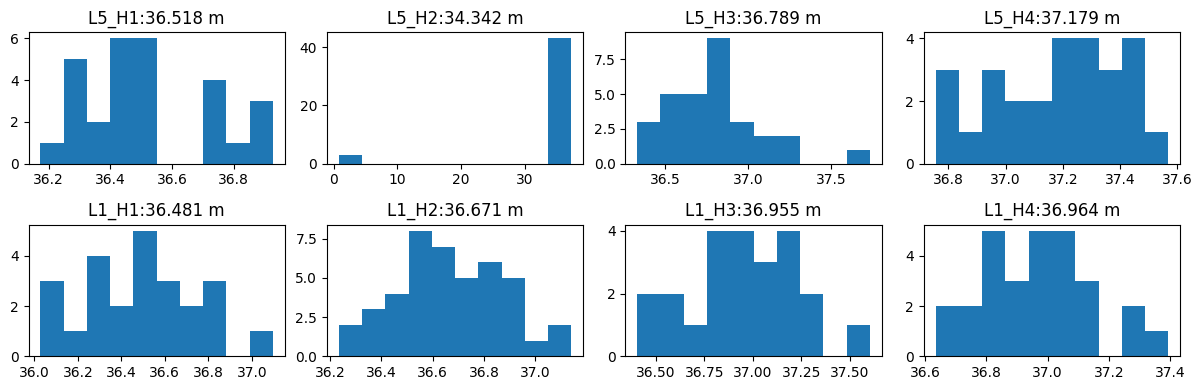

In [4]:
visualize(res, "end_height")

In [5]:
from scipy import stats
def visualize_compare(data: pd.Series):
    d1 = data.loc[data.line=="L1"]
    d5 = data.loc[data.line=="L5"]
    _, ax = plt.subplots(ncols=len(ccol), figsize=(12,3))
    for i, col in enumerate(ccol):
        ax[i].hist(d1[col], label="L1", alpha=.5)
        ax[i].hist(d5[col], label="L5", alpha=.5)
        statistic, pvalue = stats.ttest_ind(d1[col], d5[col])
        ax[i].set_title(f"{col}\npvalue={round(pvalue,3)}")
    plt.legend()
    plt.tight_layout()
    display(pd.crosstab(res.line, res.step))
    # This is a test for the null hypothesis that 2 independent samples
    # have identical average (expected) values. This test assumes that the
    # populations have identical variances by default.
    #     이는 두 개의 독립 표본이 동일한 평균(기대값)을 가진다는 귀무가설을 검정하기 위한 시험이다.
    # 이 검정은 기본적으로 모집단의 분산이 동일하다고 가정한다

step,H1,H2,H3,H4
line,,,,
L1,24,43,23,28
L5,28,46,30,27


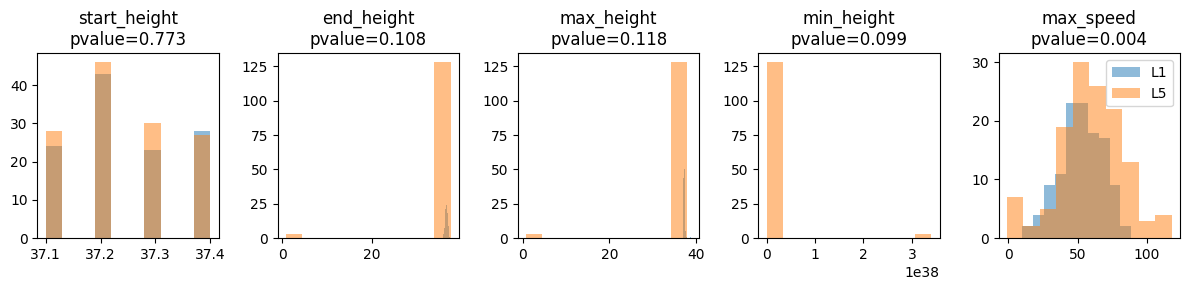

In [6]:
visualize_compare(res)

step,H1,H2,H3,H4
line,,,,
L1,20,37,19,22
L5,23,43,27,21


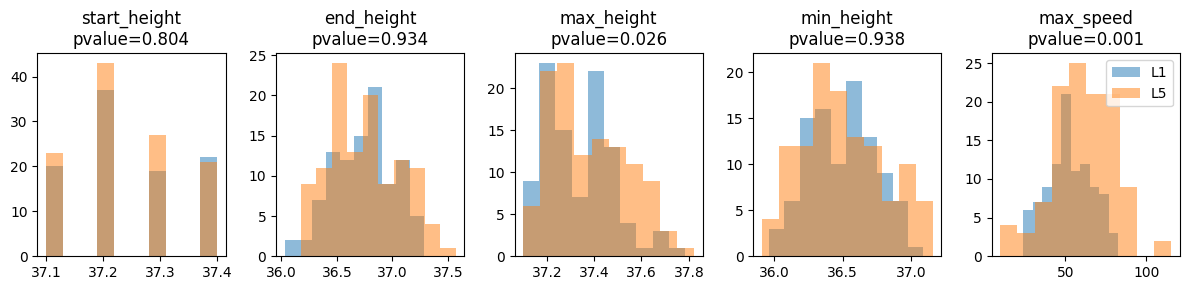

In [7]:
# remove outliers
from sklearn.preprocessing import StandardScaler
out = list()
for phase in res.phase.unique():
    x = res.loc[res.phase == phase, ccol]
    out.append(
        pd.DataFrame(
            np.abs(StandardScaler().fit_transform(x))>2, columns=ccol, index=x.index))
    
rout=pd.concat(out).sum(axis=1)
rout
res = res[rout==0].copy()
# visualize(res, "end_height")
# display(pd.crosstab(res.line, res.step))

visualize_compare(res)

L1_H4


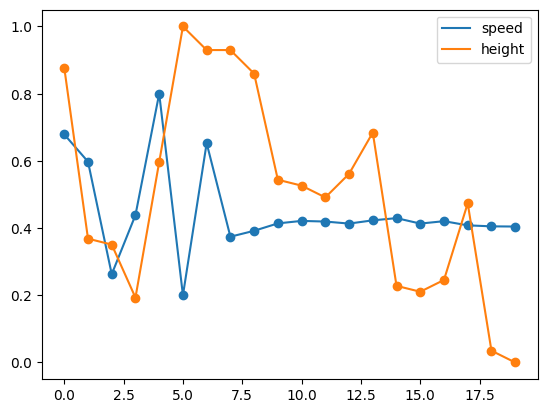

In [8]:
from sklearn.preprocessing import MinMaxScaler
r = res.loc[(res.line=="L1")&(res.step=="H4")].pipe(lambda x: x.loc[x.max_speed.idxmin()])
speed = pd.Series(MinMaxScaler((.2,.8)).fit_transform(pd.DataFrame(r.speed))[:,0])
plt.plot(speed.index, speed.values, label="speed")
plt.scatter(speed.index, speed.values)
height = pd.Series(MinMaxScaler().fit_transform(pd.DataFrame(r.height))[:,0])
plt.plot(height.index, height.values, label="height")
plt.scatter(height.index, height.values)
plt.legend()
plt.title = "L1 min"
print(r.phase)

L5_H4


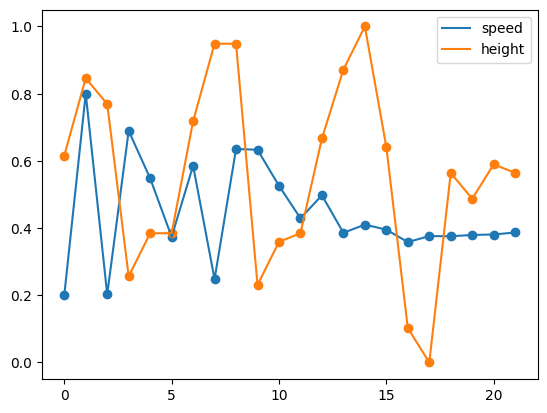

In [9]:
from sklearn.preprocessing import MinMaxScaler
r = res.loc[(res.line=="L5")&(res.step=="H4")].pipe(lambda x: x.loc[x.max_speed.idxmin()])
speed = pd.Series(MinMaxScaler((.2,.8)).fit_transform(pd.DataFrame(r.speed))[:,0])
plt.plot(speed.index, speed.values, label="speed")
plt.scatter(speed.index, speed.values)
height = pd.Series(MinMaxScaler().fit_transform(pd.DataFrame(r.height))[:,0])
plt.plot(height.index, height.values, label="height")
plt.scatter(height.index, height.values)
plt.legend()
plt.title = "L5 min"
print(r.phase)

L1_H1


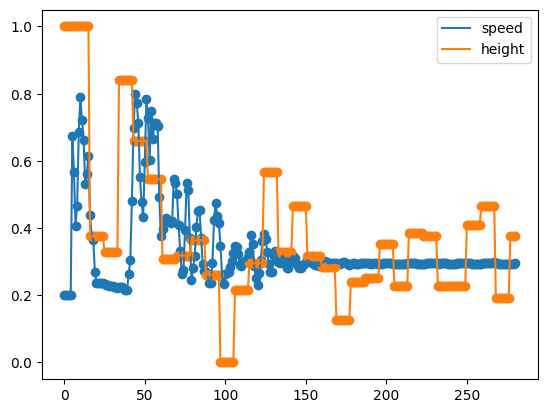

In [297]:
### from sklearn.preprocessing import MinMaxScaler
# r = res.loc[(res.line=="L1")&(res.step=="H1")].pipe(lambda x: x.loc[x.max_speed.idxmin()])
r = res.loc[(res.line=="L1")&(res.step=="H1")].pipe(lambda x: x.iloc[9,:])

speed = pd.Series(MinMaxScaler((.2,.8)).fit_transform(pd.DataFrame(r.speed))[:,0])
plt.plot(speed.index, speed.values, label="speed")
plt.scatter(speed.index, speed.values)
height = pd.Series(MinMaxScaler().fit_transform(pd.DataFrame(r.height))[:,0])
plt.plot(height.index, height.values, label="height")
plt.scatter(height.index, height.values)
plt.legend()
plt.title = "L1 max"

print(r.phase)

L5_H4


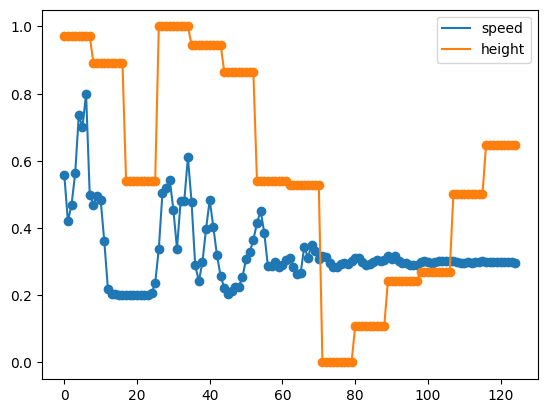

In [259]:
# from sklearn.preprocessing import MinMaxScaler
# r = res.loc[(res.line=="L5")&(res.step=="H1")].pipe(lambda x: x.loc[x.max_speed.idxmin()])
r = res.loc[(res.line=="L5")&(res.step=="H1")].pipe(lambda x: x.iloc[20])

speed = pd.Series(MinMaxScaler((.2,.8)).fit_transform(pd.DataFrame(r.speed))[:,0])
plt.plot(speed.index, speed.values, label="speed")
plt.scatter(speed.index, speed.values)
height = pd.Series(MinMaxScaler().fit_transform(pd.DataFrame(r.height))[:,0])
plt.plot(height.index, height.values, label="height")
plt.scatter(height.index, height.values)
plt.legend()
plt.title = "L5 max"
print(r.phase)

In [12]:
res.to_csv("experiments_250816.csv")

In [13]:
pd.pivot_table(
    res,
    index="line",
    columns="step",
    values=["end_height", "max_height", "max_speed"],
    aggfunc="mean"
).round(2)

end_height                      max_height                       \
step         H1     H2     H3     H4         H1     H2     H3     H4   
line                                                                   
L1        36.46  36.66  36.96  36.95      37.18  37.29  37.45  37.45   
L5        36.49  36.68  36.77  37.14      37.29  37.34  37.44  37.51   

     max_speed                       
step        H1     H2     H3     H4  
line                                 
L1       69.82  51.78  41.98  46.43  
L5       71.43  59.80  61.89  48.44

In [14]:
from scipy import stats
def visualize_compare_by_step(data: pd.Series):
    d1 = data.loc[data.line=="L1"]
    d5 = data.loc[data.line=="L5"]
    nrows = len(data.step.unique())
    ncols = len(ccol)
    _, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,8))
    for r, step in enumerate(data.step.unique()):
        for c, col in enumerate(ccol):
            ax[r][c].hist(d1.loc[d1.step==step, col], label="L1", alpha=.5)
            ax[r][c].hist(d5.loc[d5.step==step, col], label="L5", alpha=.5)
            statistic, pvalue = stats.ttest_ind(d1.loc[d1.step==step, col], d5.loc[d5.step==step, col])
            ax[r][c].set_title(f"{col}\npvalue={round(pvalue,3)}")
    plt.legend()
    plt.tight_layout()
    display(pd.crosstab(res.line, res.step))
    # This is a test for the null hypothesis that 2 independent samples
    # have identical average (expected) values. This test assumes that the
    # populations have identical variances by default.
    #     이는 두 개의 독립 표본이 동일한 평균(기대값)을 가진다는 귀무가설을 검정하기 위한 시험이다.
    # 이 검정은 기본적으로 모집단의 분산이 동일하다고 가정한다

/home/ideptor/gitworkspace/FreeDrop2/doc/jupyter/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


step,H1,H2,H3,H4
line,,,,
L1,20,37,19,22
L5,23,43,27,21


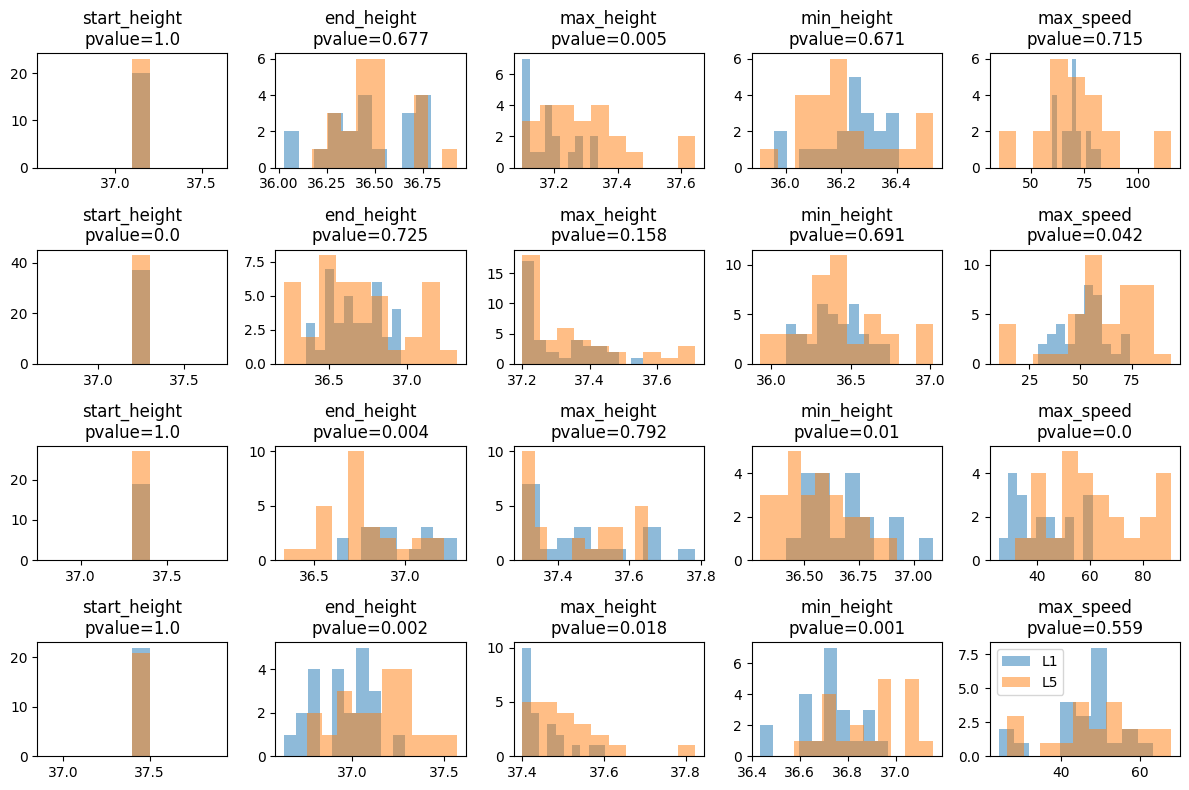

In [15]:
visualize_compare_by_step(res)

In [16]:
len(res)

212